# Lending Club Dataset: Predicting Loan Sub Grade


Lending Club risk model has assigned records to different pricing tiers, indicated within the sub_grade variable. In this notebook I will be looking at the features that are related/predictive to subgrades and attempt to explain why. 

The LC dataset has 42542 instances and 122 features. However, due to the the nature of the problem, and handling of structural issues i.e. missing values; I will be investigating the following 17 features:
        
       revol_util - revolving utilization line
       earliest_cr_line_year- borrower's earliest reported credit line was opened
       revol_bal - revolving balance
       loan_amnt - Listed amount applied by the borrowing
       term -  number of payments on the loan, values are 36 months or 60 months
       emp_length -  employment length in years
       home_ownership - rent, own, mortgage, or other 
       annual_inc - borrower's self reported annual income 
       verification_status - verification of income 
       purpose - purpose of loan
       addr_state - state of loan application
       dti - monthly debt to income ratio
       inq_last_6mths - # of inquiries in past 6 months 
       open_acc - # of open credit lines in borrowers credit file
       pub_rec - public derogatory record 
       total_acc - # of credit lines in borrower's credit file
       pub_rec_bankruptcies - public bankrupticies record
       issue_year - year loan was issued 
       loan_income_ratio - ratio of loan to income
        delinq_

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tqdm
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


In [2]:
df = pd.read_csv('LoanStats3a.csv')

In [3]:
df.shape

(42542, 122)

# Summary of missing values

There were a ton of missing data here and consequently many columns were dropped. 67 columns had all nan's in them and can be found under the variable cols_with_all_nans. 

'mths_since_last_delinq', 'id','next_pymnt_d' 'mths_since_last_record' were dropped because majority values were missing

'tax_liens','collections_12_mths_ex_med','chargeoff_within_12_mths' was dropped since all  instance are 0.0. There is no valuable information coming from this. 

'desc' was dropped; it can be used in a separate NLP analysis.

'title' was dropped because it is just a long drawn out version of 'purpose'; although this can be used in conjunction with 'desc' in NLP analysis

'emp_length' was imputed with the median amount of y ears

All other randomly missing values had the rows dropped; the number of dropped rows was insignificant compared to the size of the data. 

There are 45 columns after dealing with missing values



In [4]:
df.isnull().sum()

id                                     42539
member_id                              42542
loan_amnt                                  7
funded_amnt                                7
funded_amnt_inv                            7
term                                       7
int_rate                                   7
installment                                7
grade                                      7
sub_grade                                  7
emp_title                               2631
emp_length                                 7
home_ownership                             7
annual_inc                                11
verification_status                        7
issue_d                                    7
loan_status                                7
pymnt_plan                                 7
url                                    42542
desc                                   13299
purpose                                    7
title                                     19
zip_code  

In [5]:
cols_with_all_nans = []
for col in df.columns:
    if df[col].isnull().sum() == df.shape[0]:
        cols_with_all_nans.append(col)

In [6]:
cols_with_all_nans

['member_id',
 'url',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_hi_

In [7]:
def dealing_with_nulls(data):    
    # getting rid of all columns who's rows are all null
    for col in data.columns:
        if data[col].isnull().sum() == data.shape[0]:
            data.drop(col, axis=1, inplace = True)
    
    #dropping rows in loan_amnt with nulls
    for index in data[data['loan_amnt'].isnull()==True].index:
        data.drop(index, axis=0, inplace=True)

    data.drop(data.ix[data.earliest_cr_line.isnull()==True].index, axis=0, inplace= True)

    data.drop(['desc', 'emp_title','mths_since_last_delinq', 'id',
               'next_pymnt_d','mths_since_last_record','title',
               'collections_12_mths_ex_med','chargeoff_within_12_mths',
               'tax_liens' ], axis=1, inplace= True)
    
    revol_util_median = df[df.revol_util.isnull()!=True]['revol_util'].apply(lambda x: float(re.sub('%', '', x) )).median()
    
    for i in data.revol_util[data.revol_util.isnull()==True].index:
        data.revol_util[i] = '{}%'.format(revol_util_median)

    # changing dtype of entire row to floats
    data.revol_util = data.revol_util.apply(lambda x: float(re.sub('%', '', x) ))
    
    # Dealing with last_pymnt_d and last_credic_pull_d, pub_rec_bankruptcies
    #droppiing rows of last_pymnt_d, last_credic_pull_d, pub_rec_bakrupticies 
    data.drop(data[data.last_credit_pull_d.isnull()==True].index, axis=0, inplace=True)
    data.drop(data[data.last_pymnt_d.isnull()==True].index, axis=0, inplace=True)
    data.drop(data[data.pub_rec_bankruptcies.isnull()==True].index, axis=0, inplace=True)
    
    #dropping rows with null values in earliest_cr_line
    data.drop(df[df.earliest_cr_line.isnull()==True].index, axis=0, inplace=True)
    
    return data

# Dropping features that take effect after assigning subgrade

Since the goal is to find out which factors effect sub_grade... the idea is to capture all features that are collected before an actual grade is assigned. For example, interest rate and loan status are features that come after getting a loan grade so they will be dropped. If this was not the case, interest rate alone would have a 95% accuracy in predicting loan grade. The features dropped can be found under the function 'cleaning' seen below.

After this...there will be a total of 16 features to explore

In [8]:
def cleaning(data):
    data.drop(['pymnt_plan','initial_list_status', 'out_prncp', 
                          'out_prncp_inv','delinq_amnt','acc_now_delinq',
                          'application_type','policy_code',
                          'zip_code', 'last_pymnt_d',
                          'last_credit_pull_d','grade','int_rate',
                          'total_pymnt', 'last_pymnt_amnt', 'installment',
                           'total_rec_int','loan_status','collection_recovery_fee',
                           'total_rec_prncp','funded_amnt', 
                           'total_pymnt_inv', 'funded_amnt_inv','recoveries','total_rec_late_fee',

              ], 1,inplace=True)

    #emp_length
    data['emp_length'] = data['emp_length'].str.extract('(\d+)').astype(float)
    
    #term
    data['term'] =  df['term'].apply(lambda x:0 if x==' 36 months' else 1)
    
    #issue_d
    data['issue_d'] = data['issue_d'].apply(lambda x: re.sub('[^a-zA-Z0-9]','-20' , x))
    data['issue_d'] = pd.to_datetime(data['issue_d'])
    data['issue_year'] = data['issue_d'].apply(lambda x: x.year)
    data.drop('issue_d', axis=1, inplace=True)
    
    #earliest_credit_line
    
    data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda x: re.sub('[^a-zA-Z0-9]','-19' , x)
                             if int(x.split('-')[1]) >11 
                             else re.sub('[^a-zA-Z0-9]','-20' , x))
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
    data['earliest_cr_line_year'] = data['earliest_cr_line'].apply(lambda x: x.year)
    data.drop('earliest_cr_line', axis=1, inplace=True)
    
    return data

In [9]:
def make_line_box_plot(feature, order=None, hue=None):
    
        median= []
        for i in range(len(sub_grade_encoder.classes_)):
            median.append(df[df['sub_grade_encoded']==i][feature].median())


        plt.figure(figsize = (9,9))
        sns.set_style('whitegrid')
        sns.set(font_scale=1)
        plt.xlabel('sub_grade')
        plt.ylabel('{} median'.format(feature))
        plt.title('{} vs sub_grade'.format(feature))
        sns.pointplot(x=sub_grade_encoder.classes_, y=median, color= 'green')
 
    
     
        plt.figure()
        sns.factorplot(kind = 'box', x='sub_grade_encoded', y=feature, data= df, 
                       order= order, 
                       aspect=1.5, size=6, color='red'
                       )

In [10]:
df= dealing_with_nulls(df)

In [11]:
df.shape

(41088, 45)

In [12]:
df=cleaning(df)

df['emp_length'].fillna(df['emp_length'].median(),inplace=True)


Adding new feature: income to loan ratio

In [13]:
df['income_loan_ratio'] = df.annual_inc/df.loan_amnt

In [14]:
df.shape

(41088, 21)

In [15]:
df.columns

Index(['loan_amnt', 'term', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'issue_year',
       'earliest_cr_line_year', 'income_loan_ratio'],
      dtype='object')

# Distribution of Subgrades
The sub_grade encoding is the folllowing:

    A1-A5 => 0-4; B1-B5 => 5-9; C1-C5 => 10-14; 
    D1-D5 => 15-19; E1-E5 => 20-24; F1-F5 => 25-29; 
    G1-G5 => 30-34  

In [102]:
sub_grade_encoder = LabelEncoder().fit(df.sub_grade)
df['sub_grade_encoded'] = sub_grade_encoder.transform(df.sub_grade)

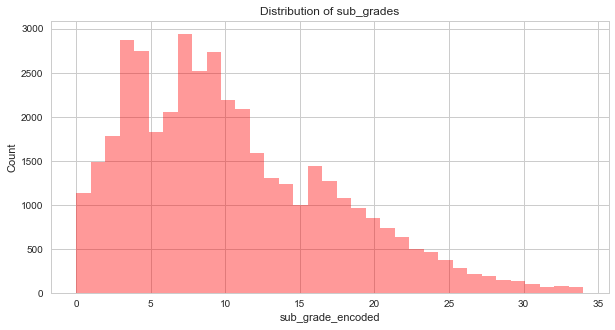

In [17]:
plt.figure(figsize = (10,5))
sns.set_style('whitegrid')
sns.distplot(df.sub_grade_encoded, color="r", bins=35, kde=False,)
plt.title('Distribution of sub_grades')
plt.ylabel('Count')

# Correlation Heat Map
Looking at the sub_grade_encoded row...the features that correlate the most are revol_util, loan_amnt, term, and inq_last_6_mths. 


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5]),
 <a list of 17 Text xticklabel objects>)

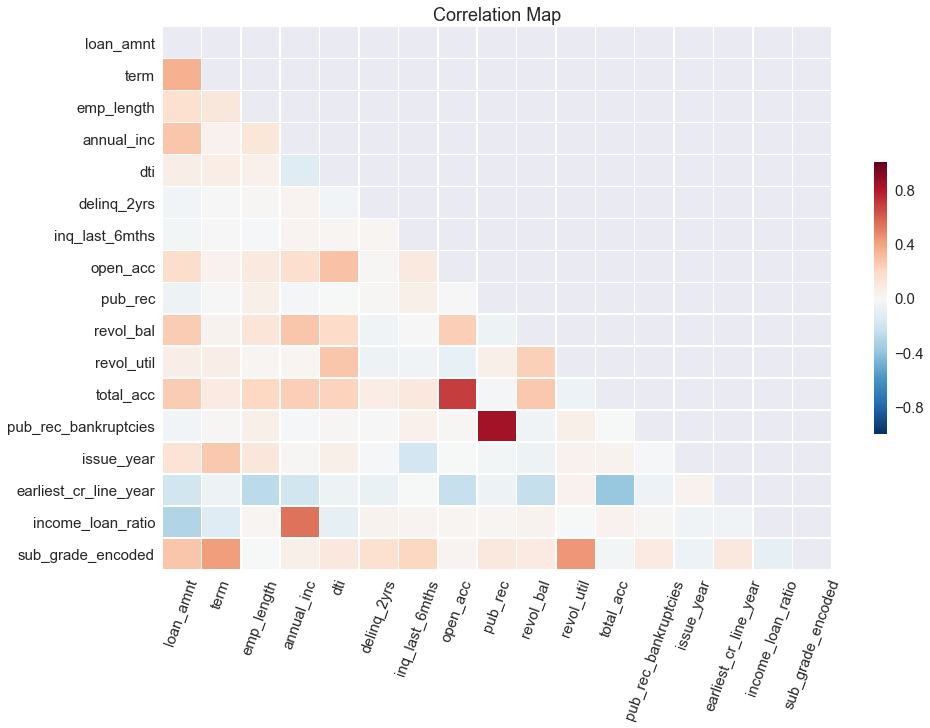

In [18]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.5)
plt.figure(figsize = (15,10))
sns.heatmap(corr, mask = mask,linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Map')
plt.xticks(rotation = 70)


In [19]:
corr.sub_grade_encoded[corr.sub_grade_encoded>.2].index

Index(['loan_amnt', 'term', 'inq_last_6mths', 'revol_util',
       'sub_grade_encoded'],
      dtype='object')

# Features to Investigate:

The following features will be analyzed using boxplot, lineplot, and distrubtion plot. Features  will be plotted against sub_grade; the goal here is to see if there are any significant variations in the features as sub_grade moves from A1-G5.      

    Features to be investigated:
        revol_util,
        revol_bal,
        open_acc
        earliest_cr_line_year
        loan_amnt, 
        dti,
        inq_last_6mths, 
        issue_year
        annual_inc, 
        addr_state, 
        term,
        pub_rec, 
        pub_rec_bankruptcies
        open_acc
        emp_length
        income_loan_ratio 


# Revolution Line Utilization Rate

There is a strong correlation here between revol_util and sub_grades. A high revol_util score can negatively effect credit score which in turn would effect the loan grade. This feature will be one of the top predictors

In [20]:
len(df[df.revol_bal>=.3])

40076

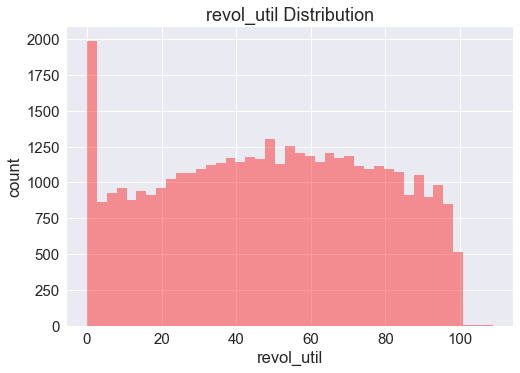

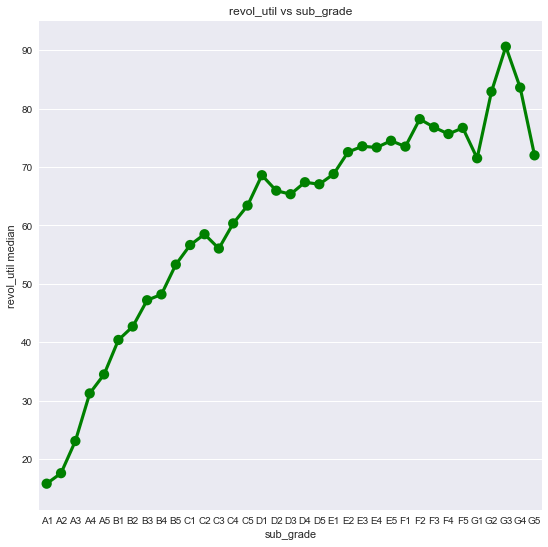

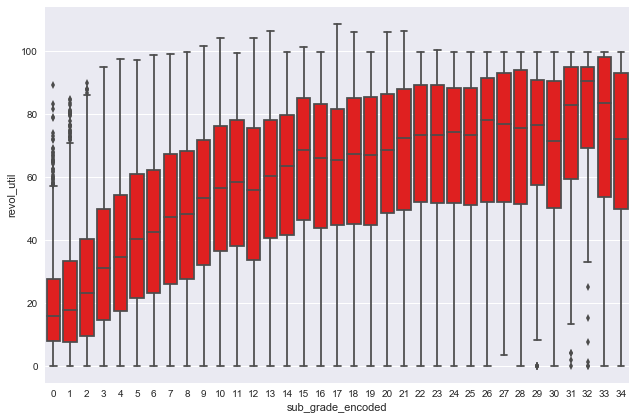

In [21]:
plt.figure()
plt.ylabel('count')
sns.set_style('whitegrid')
sns.distplot(df.revol_util, color = 'red',kde=False )
plt.title('revol_util Distribution')
make_line_box_plot('revol_util',hue='term')

# Revolving Balance

Slightly upward trend here but does not look significant 

(0, 80000)

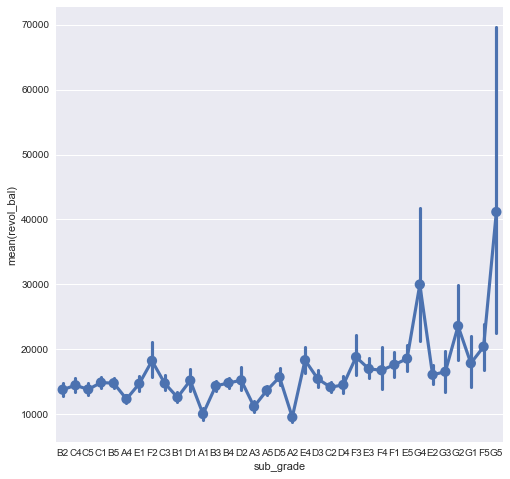

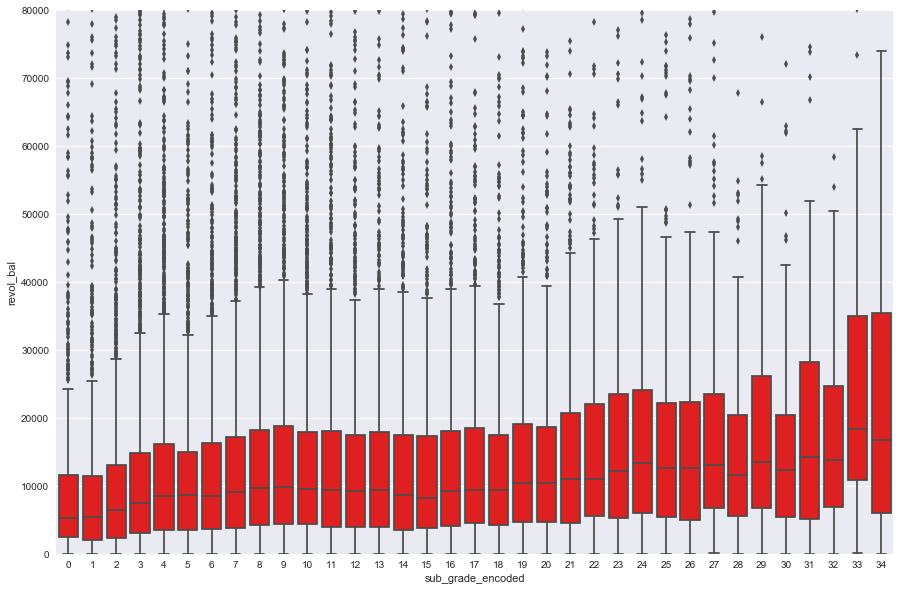

In [88]:
plt.figure(figsize=(8,8))
sns.pointplot(df.sub_grade, df.revol_bal)

plt.figure(figsize=(15,10))

sns.boxplot(df.sub_grade_encoded, df.revol_bal, color='red')
plt.ylim(0,80000)

# Total Amount of Credit Account

No trend here

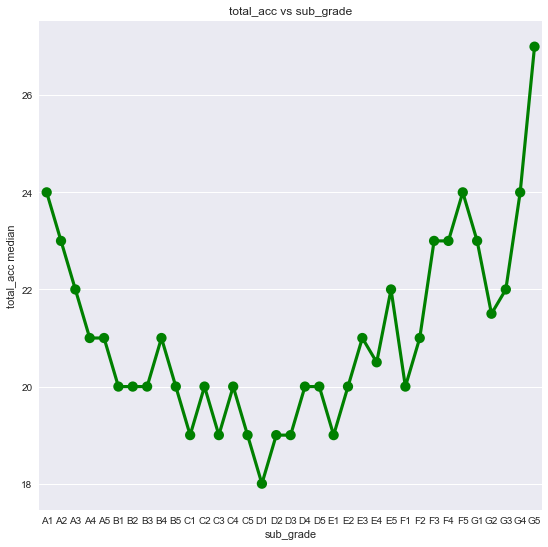

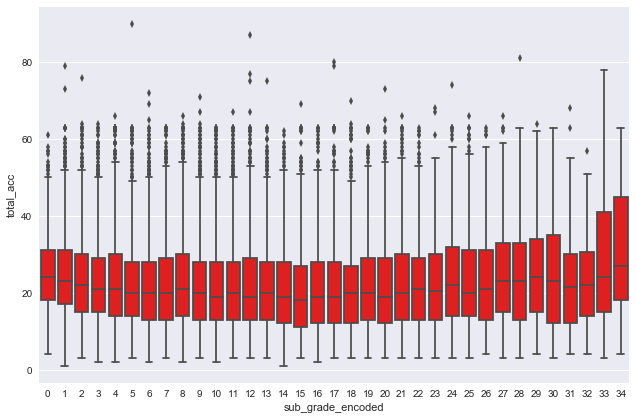

In [22]:
make_line_box_plot('total_acc')

### Open Credit Account

Not much variation here, doesn't look like it will add any predictive power.

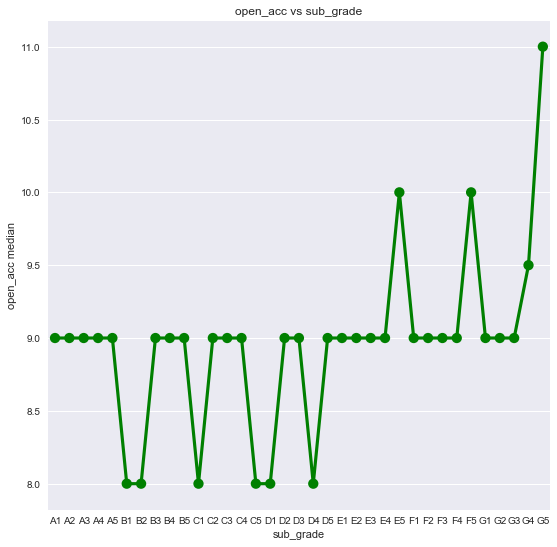

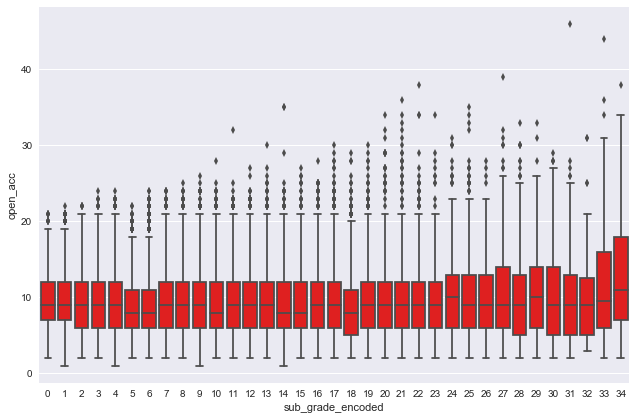

In [23]:
make_line_box_plot('open_acc')

### Earliest Credit line year

Slight variations can we seen from A1 to A3 and G2 to G3. However these are still insignificant and will not have predictive power  

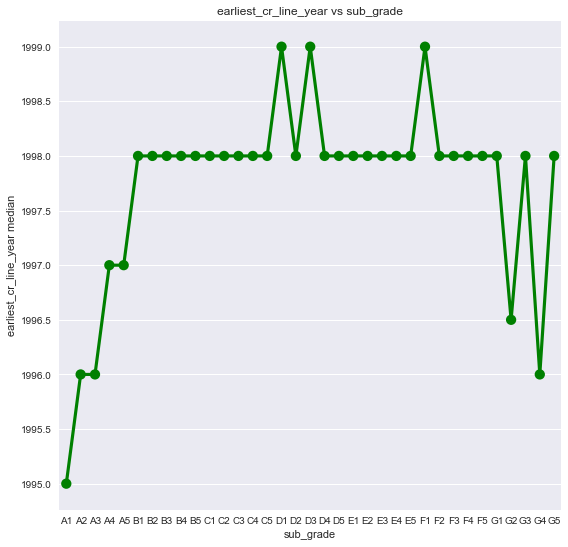

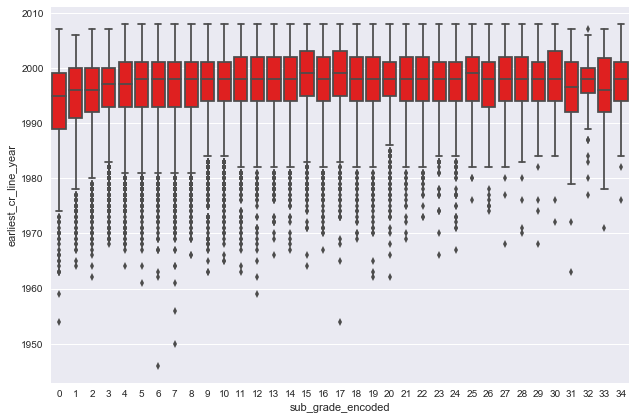

In [24]:
make_line_box_plot('earliest_cr_line_year')

###  Loan Amount


Loan amount has the 2nd highest linear correlation amongst all the other features.I suspect this will have some predictive power. There is an upward trend from A2 to B2 and D1 to F5.   

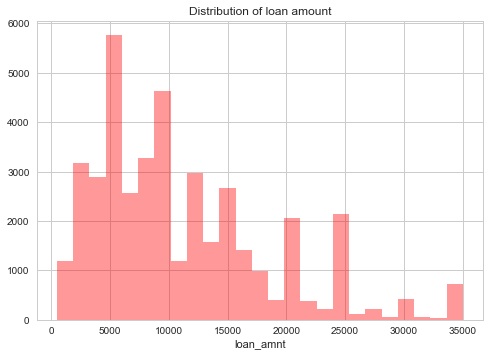

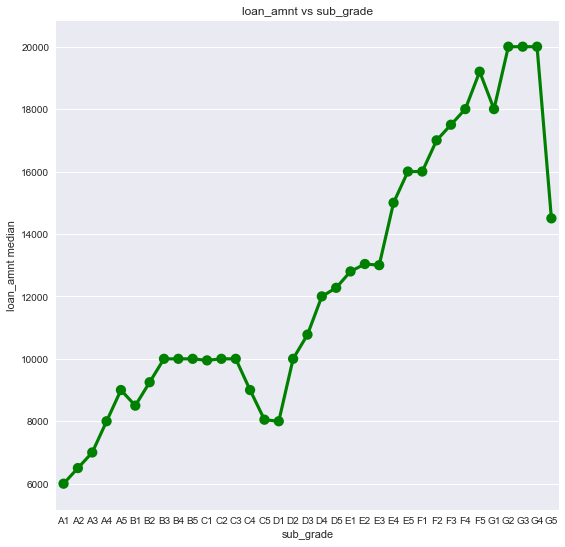

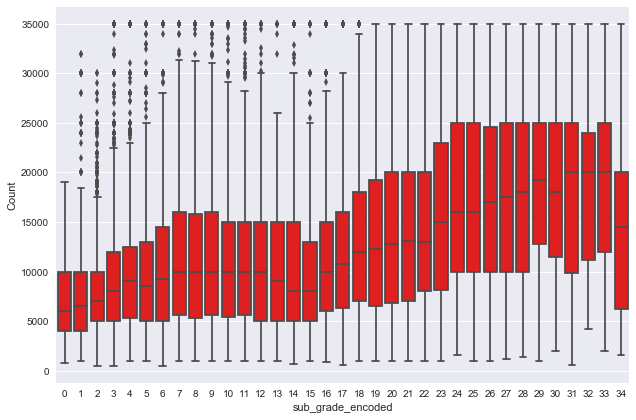

In [25]:
sns.set_style('whitegrid')
sns.distplot(df.loan_amnt, kde=False, color = 'red', bins = 25)
plt.title('Distribution of loan amount')
make_line_box_plot('loan_amnt')
plt.ylabel('Count')

### Debt to Income Ratio

No significant correlation

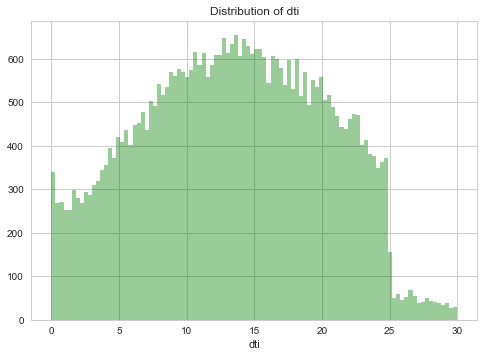

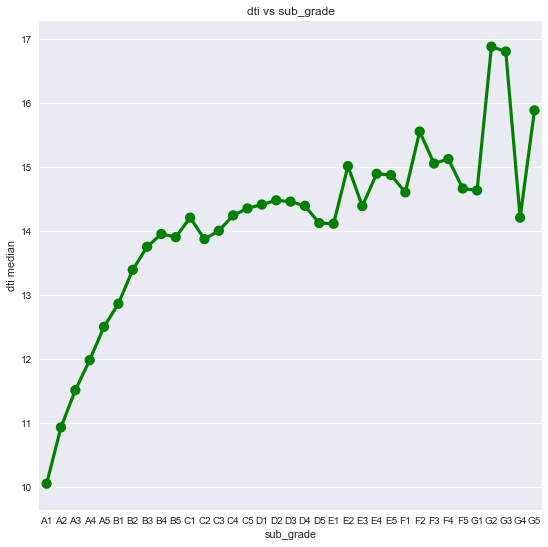

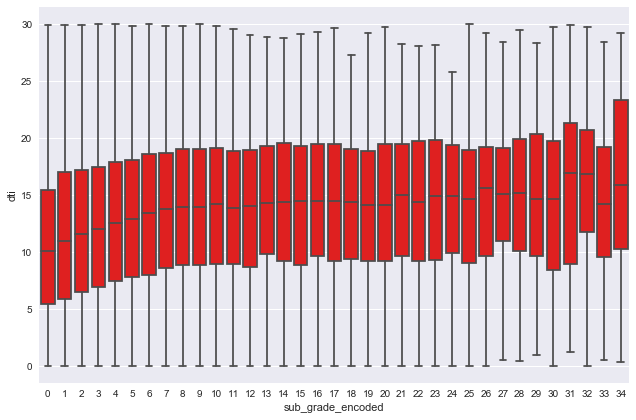

In [26]:
sns.set_style('whitegrid')
sns.distplot(df.dti, kde=False, color = 'green', bins = 100)
plt.title('Distribution of dti')
make_line_box_plot('dti')

### Income to loan ratio

Income to ratio has a downward trend and may be a good candidate as a predictor. This variable puts the borrower's loan amount into context, giving a better idea of whether or not the borrower is capable of paying back the loan.

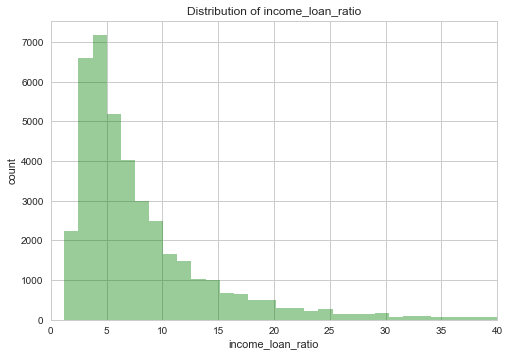

In [27]:
sns.set_style('whitegrid')
sns.distplot(df.income_loan_ratio, kde=False, color = 'green', bins = 1000)
plt.xlim(0,40)
plt.title('Distribution of income_loan_ratio')
plt.ylabel('count')

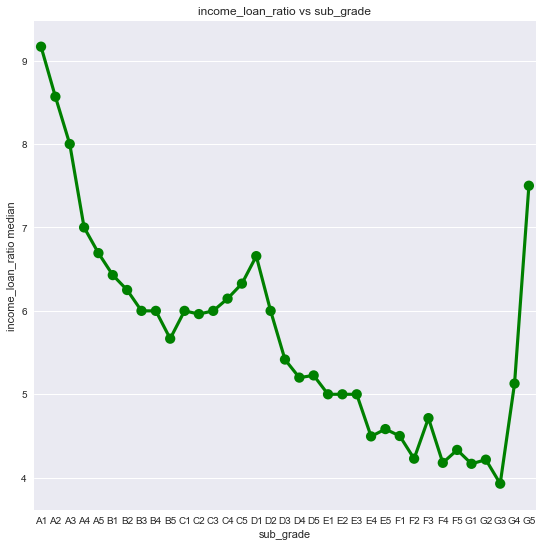

In [28]:
median= []
for i in range(len(sub_grade_encoder.classes_)):
            median.append(df[df['sub_grade_encoded']==i]['income_loan_ratio'].median())


plt.figure(figsize = (9,9))
sns.set_style('whitegrid')
sns.set(font_scale=1)
plt.xlabel('sub_grade')
plt.ylabel('{} median'.format('income_loan_ratio'))
plt.title('{} vs sub_grade'.format('income_loan_ratio'))
plt.xlim(0,200000)
sns.pointplot(x=sub_grade_encoder.classes_, y=median, color= 'green')

(0, 40)

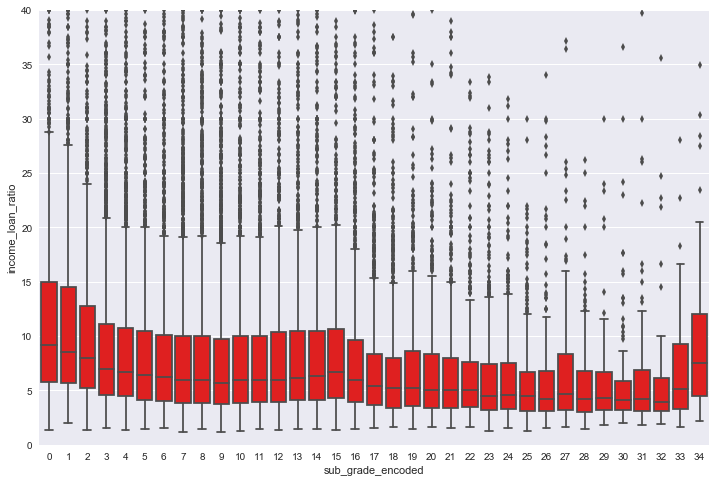

In [29]:
plt.figure(figsize=(12,8))
sns.boxplot(df.sub_grade_encoded, df.income_loan_ratio, color='red')
plt.ylim(0,40)

### Annual Income

There is a slight upward trend after E3. plot shows that the higher someone is earning annually, the more likely they will get placed in a higher loan grade. This doesn't make sense. Well if you look at the plot above (income to loan ratio) it shows that poeple with higher grade have a low income to loan ratio. People may be making more money, but they are also asking for more loan amnt

(0, 200000)

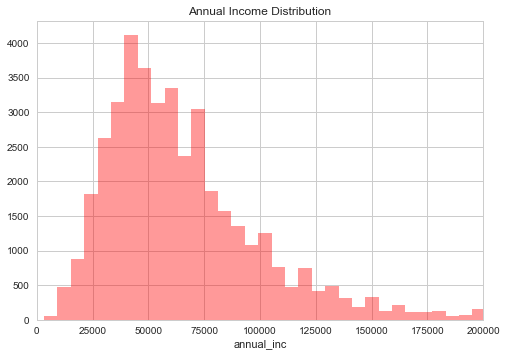

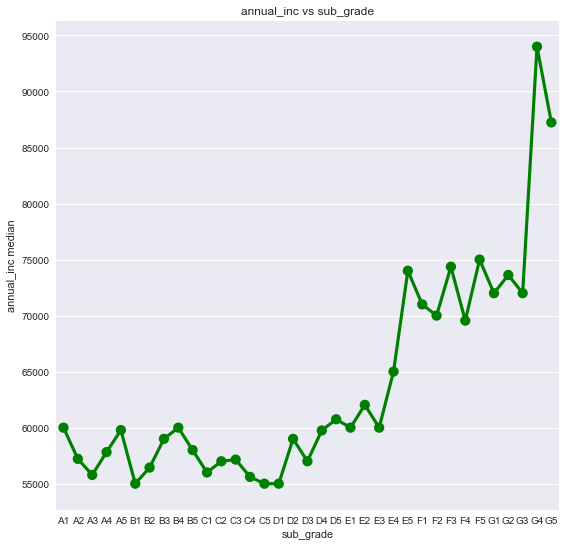

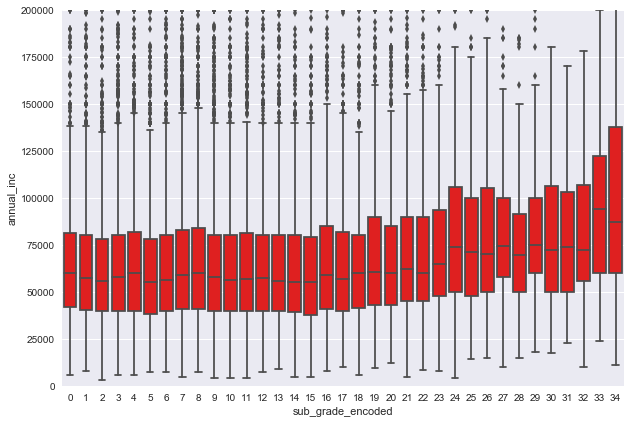

In [30]:
plt.figure()
sns.set_style('whitegrid')
sns.distplot(df.annual_inc, color='red', kde= False, bins= 1000)
plt.xlim(0,200000)
plt.title('Annual Income Distribution')
median= []
for i in range(len(sub_grade_encoder.classes_)):
            median.append(df[df['sub_grade_encoded']==i]['annual_inc'].median())


plt.figure(figsize = (9,9))
sns.set_style('whitegrid')
sns.set(font_scale=1)
plt.xlabel('sub_grade')
plt.ylabel('{} median'.format('annual_inc'))
plt.title('{} vs sub_grade'.format('annual_inc'))
plt.xlim(0,200000)
sns.pointplot(x=sub_grade_encoder.classes_, y=median, color= 'green')



plt.figure()
sns.factorplot(kind = 'box', x='sub_grade_encoded', y='annual_inc', data= df, 
               
               aspect=1.5, size=6, color='red'
               )
plt.ylim(0,200000)

In [31]:
#makes 6 million a year and applying for 5000 loan?? something is not right here
df[df.annual_inc>=3000000][['loan_amnt', 'annual_inc','purpose', 'verification_status']]

,loan_amnt,annual_inc,purpose,verification_status
29708,25000.0,3900000.0,home_improvement,Not Verified
30176,5000.0,6000000.0,home_improvement,Source Verified


There is person who make 6 million dollars a year applying for a 5000 loan. This seems like an extra 0 was accidentally added to the salary. If someone were to make 6 mil a year...5000 is like a days pay check. 

Another case where a person makes 3.9 million applying for a 25k loan...This also seems like a mistake. That's the equivalent of a person making 100k a year applying for a 600 loan. 

### Bankruptcies

This seems like it should be a good predictor...however only about 4% of the sample set actually go bankrupt.

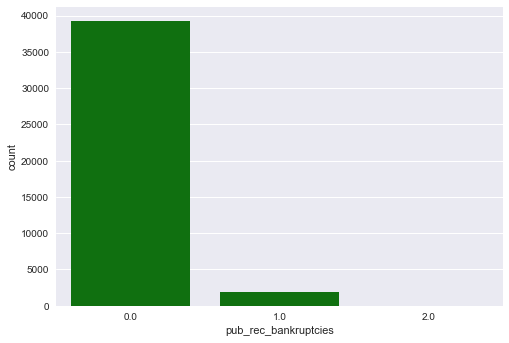

In [33]:
sns.countplot(df.pub_rec_bankruptcies, color='green')

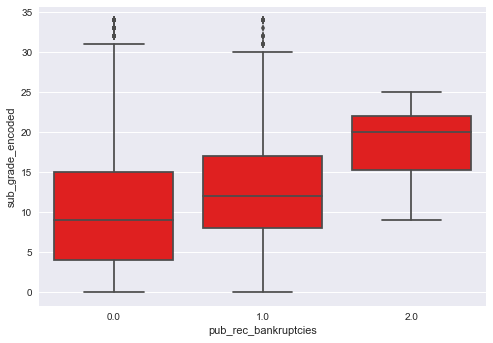

In [34]:

sns.boxplot(df.pub_rec_bankruptcies, df.sub_grade_encoded, color= 'red')

### Derogatory Public Records

Same analysis as pub_rec_bankruptcies

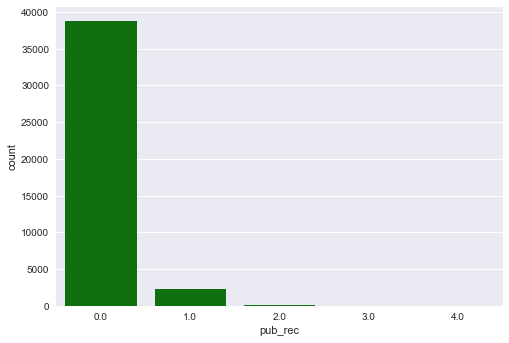

In [35]:
sns.countplot(df.pub_rec, color = 'green')

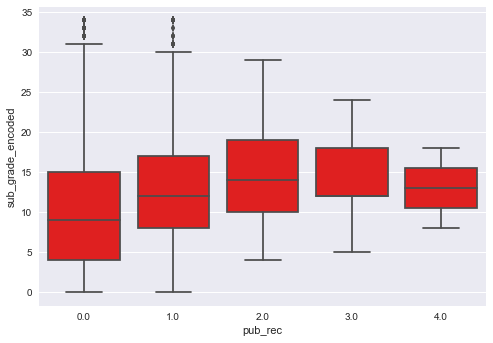

In [36]:
sns.boxplot(df.pub_rec, df.sub_grade_encoded, color='red')

### Purpose of Loan

The majority of the reasons poeple are applying for loans is for debt consolidation. Small business and house loans have higher subgrades in comparison to the rest while the lowest is buying a car. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

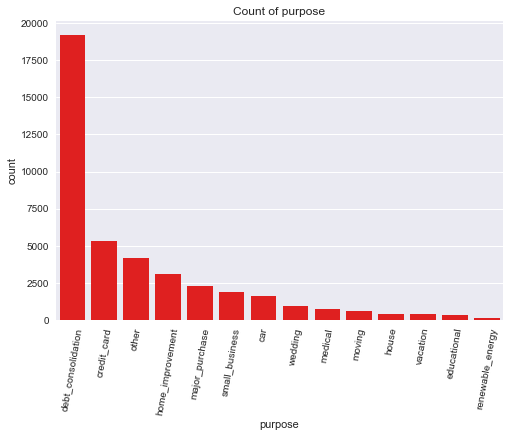

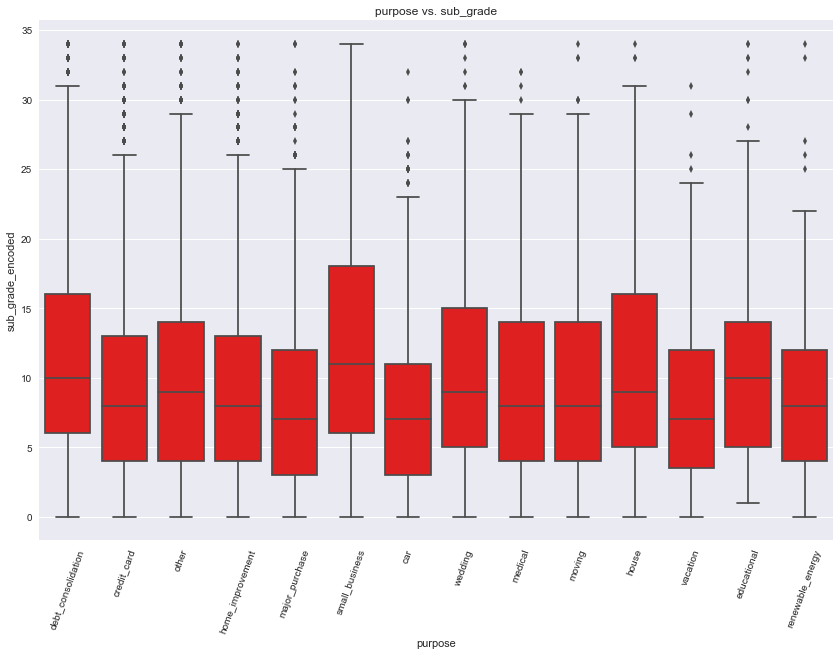

In [37]:
plt.figure()
sns.countplot(df.purpose, color='red', order= df.purpose.value_counts().index)
plt.xticks(rotation=80)
plt.title('Count of purpose')


plt.figure(figsize=(10,5))
sns.factorplot(kind='box', x='purpose',y='sub_grade_encoded', data=df, 
            color = 'red',
            aspect=1.5, size=8,
            order= df.purpose.value_counts().index)
                
plt.title('purpose vs. sub_grade')
plt.xticks(rotation= 70)



### Address State

California is by far the state that LC issues out loans to the most, almost doubling the loan count of the runner up state, New York. But, from the boxplot there doesnt seem to be much variation of subgrade moving from state to state with an exception of a few. Iowa, Tenessee, and Missouri have noticably higher subgrades than the rest of the states. However, these states' # of loans issued are low at 8, 16, and 24 respectively.      

In [38]:
len(df[df.addr_state=='MS'])

24

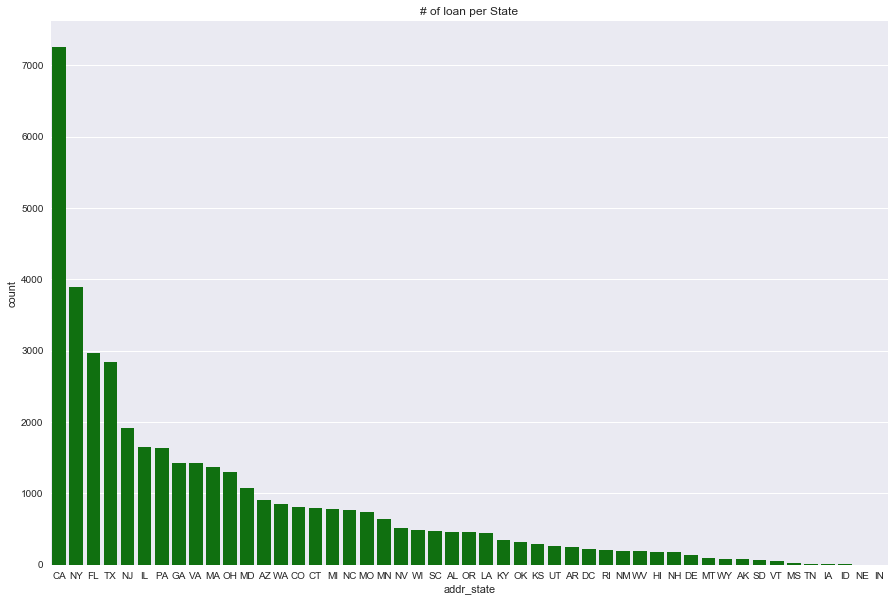

In [39]:
plt.figure(figsize = (15,10))
sns.countplot(df.addr_state, color ='green', order = df.addr_state.value_counts().index)
plt.title('# of loan per State')

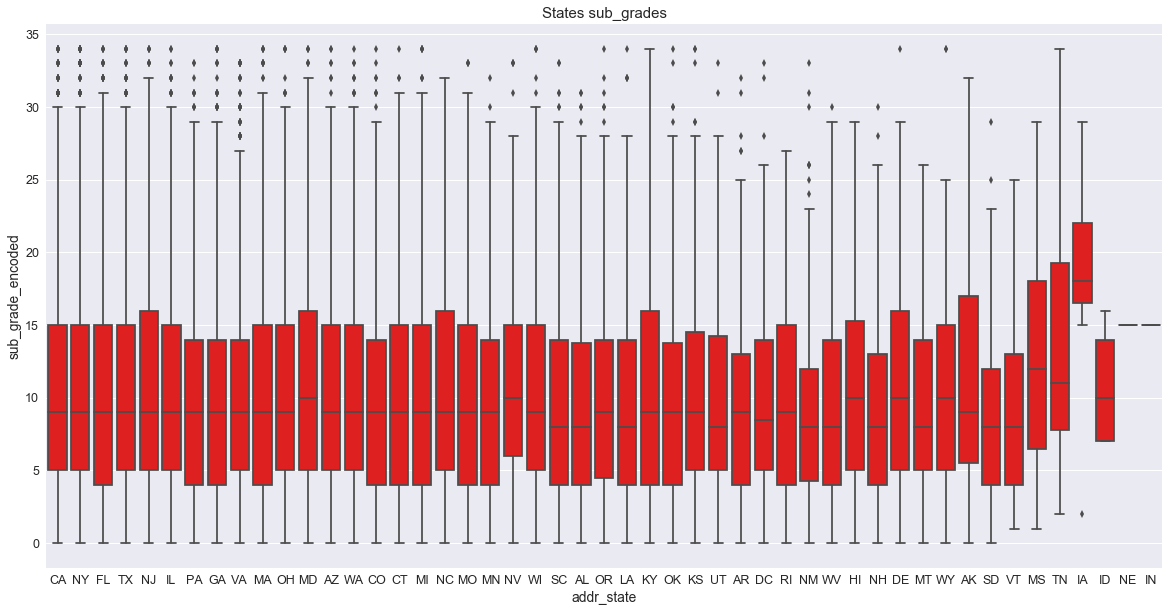

In [40]:
plt.figure(figsize = (20,10))
sns.set(font_scale=1.25)
sns.boxplot(df.addr_state, df.sub_grade_encoded,color='red',order = df.addr_state.value_counts().index )
plt.title('States sub_grades')

### Term 
0 = 36 months; 1 = 60 months

Term seems like a good candidate as a predictor for subgrades. The boxplots shows a distinct difference between 36 months and 60 months. 

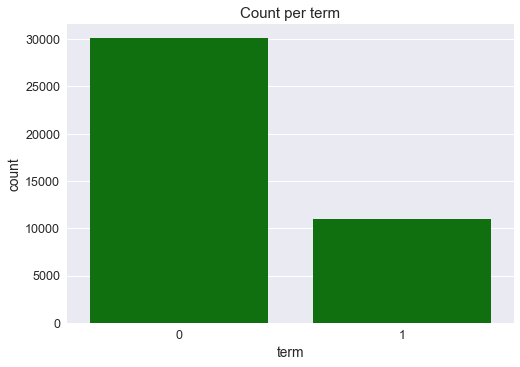

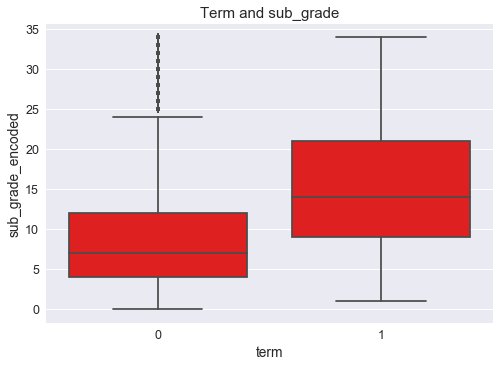

In [41]:
plt.figure()
sns.countplot(df.term, color = 'green')
plt.title('Count per term')

plt.figure()
sns.boxplot(df.term, df.sub_grade_encoded, color='red')
plt.title('Term and sub_grade')

### Home Ownership
looks insignificant

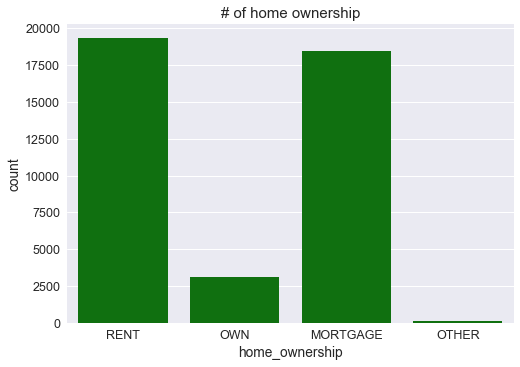

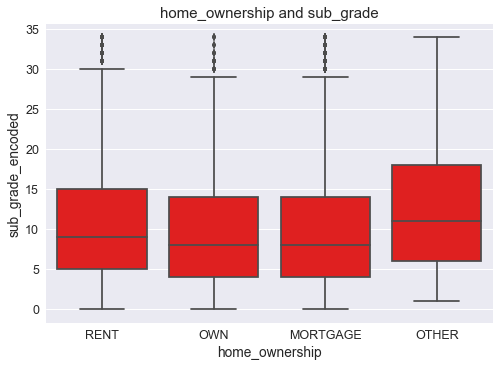

In [42]:
plt.figure()
sns.countplot(df.home_ownership, color=  'green')
plt.title('# of home ownership')


plt.figure()
sns.boxplot(df.home_ownership, df.sub_grade_encoded, color = 'red')
plt.title('home_ownership and sub_grade')

### Verification Status

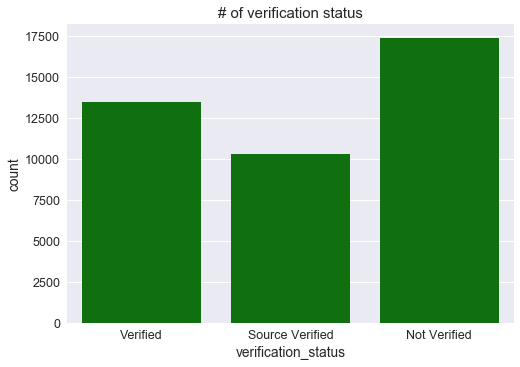

In [43]:
sns.countplot(df.verification_status, color = 'green')
plt.title('# of verification status')

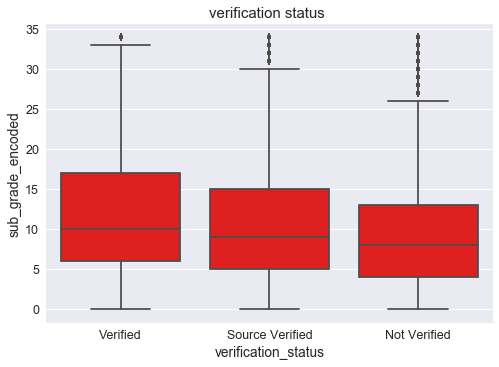

In [44]:
sns.boxplot(df.verification_status, df.sub_grade_encoded, color='red')
plt.title('verification status ')

# # of Inquiries within last 6 months

 This seems like it'd be a good candidate. People with high frequency of inquiries within a short period of time can be labeled as 'credit seeking behavior.' They are desparate for money or have been rejeceted from other lenders and are in need of cash.

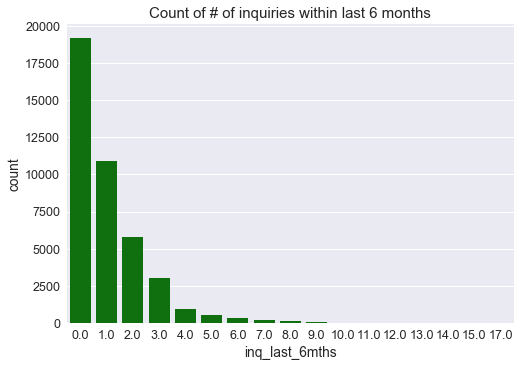

In [45]:
sns.countplot(df.inq_last_6mths, color = 'green')
plt.title('Count of # of inquiries within last 6 months')

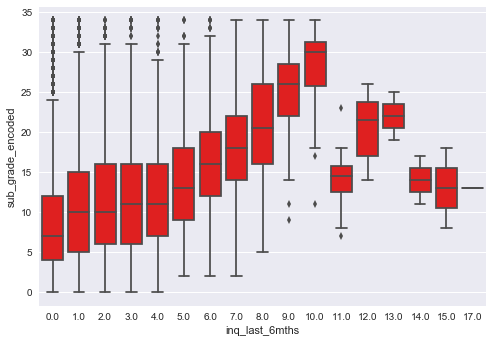

In [104]:
sns.boxplot(df.inq_last_6mths, df.sub_grade_encoded, color = 'red')

In [ ]:
df.loan_

## Grade portfolio and loan status per year

The plots here show LC's grade portfolio per year and how well their model did. Each year they have improved in terms of profit and average dollar per person. 2008 was their worst model; they lost about $600,000...averaging a loss of -400 dollars per person. From 2008 to 2009 they adjusted their portfolio to include 11 percent more grade A and B and cut back on their grade E, F, and G which resulted in about 800 dollar per person. They're growing at exponntial rate. Each year the amount of loans they give out double or triple...along with their profit. 

In [98]:
df = pd.read_csv('LoanStats3a.csv')
df = dealing_with_nulls(df)

df['issue_d'] = df['issue_d'].apply(lambda x: re.sub('[^a-zA-Z0-9]','-20' , x))
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['issue_year'] = df['issue_d'].apply(lambda x: x.year)
df.drop('issue_d', axis=1, inplace=True)

df['profit_loss'] = df.total_pymnt - df.loan_amnt

df['loan_status'] = df['loan_status'].apply(lambda x: 'Fully Paid' if (x=='Fully Paid' or x=='Does not meet the credit policy. Status:Fully Paid') else 'Charged Off')

df['count'] = 1
df_year_grade = df.groupby(['issue_year','grade']).sum()[['count']]
df_year_loan_status = df.groupby(['issue_year','loan_status']).sum()[['count']]


2008: Profit:-666188.4210357008 
      Avg Profit/Person: -413.0120403197153 
      # of Loans: 1613

2009: Profit:4214367.71079801 
      Avg Profit/Person: 800.9060643857869 
      # of Loans: 5262

2010: Profit:8980281.15936494 
      Avg Profit/Person: 717.8482141778529 
      # of Loans: 12510

2011: Profit:27985612.92574509 
      Avg Profit/Person: 1290.6707063480649 
      # of Loans: 21683



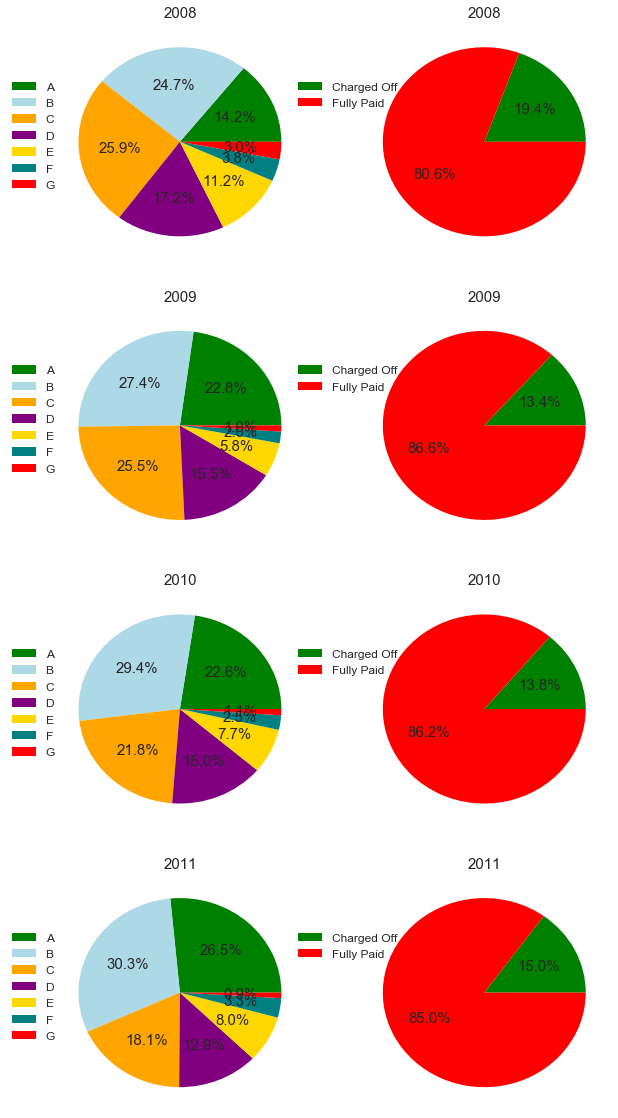

In [48]:
colors = ['green', 'lightblue', 'orange', 'purple', 'gold','teal','red']
color = ['green','red']
years = [2008,2009,2010,2011]
plt.figure(figsize=(10,20))
counter_1 = 1
counter_2 = 2

for year in years:
    
    profit = df[df['issue_year']==year]['profit_loss'].sum()
    print('{}: Profit:{} \n      Avg Profit/Person: {} \n      # of Loans: {}\n'.format(year, profit, profit/len(df[df['issue_year']==year]),df[df['issue_year']==year].shape[0] ))
   
    plt.subplot(4,2,counter_1)
    figure=(25,10)
    plt.pie(df_year_grade.loc[year], colors=colors, autopct='%1.1f%%')
    plt.legend(labels=['A','B','C','D','E','F','G'], bbox_to_anchor=(0.05,0.8),loc='best', fontsize=12)
    plt.axis='equal'
    plt.title(year,fontsize=15)
       
    
    plt.subplot(4,2,counter_2)
    figure=(25,10)
    plt.pie(df_year_loan_status.loc[year], colors=color, autopct='%1.1f%%')
    plt.axis='equal'
    plt.title(year,fontsize=15)
    plt.legend(labels=['Charged Off', 'Fully Paid'],bbox_to_anchor=(0.2,0.8),loc='bottom right', fontsize=12 )
    
    counter_1 += 2
    counter_2 += 2
    
    
    

# Modeling

In [49]:
df = pd.read_csv('LoanStats3a.csv')
df = dealing_with_nulls(df)
df = cleaning(df)
df['emp_length'].fillna(df['emp_length'].median(),inplace=True)
df['income_loan_ratio'] = df.annual_inc/df.loan_amnt

In [50]:
df.pub_rec = df.pub_rec.apply(lambda x: 0 if x==0 else 1 )
df.inq_last_6mths = df.inq_last_6mths.apply(lambda x: 0 if x==0 else 1 )
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.apply(lambda x: 0 if x==0 else 1 )
df1 = pd.get_dummies(df, columns=['delinq_2yrs','issue_year', 'home_ownership', 'verification_status','purpose' ])
df1.drop(['addr_state'], axis=1, inplace=True)

In [51]:
X = df1.drop(['sub_grade'], axis=1)
y = df[['sub_grade']]
y_encoder = LabelEncoder().fit(y)
y = y_encoder.transform(y)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
sss= StratifiedShuffleSplit(n_splits=5,test_size=.2,train_size=.8, random_state=0 )
params = {'n_estimators':[500],'max_depth':[13]}
rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=sss, n_jobs=-1)

In [53]:
rf.fit(xtrain,ytrain)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=0.8),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500], 'max_depth': [13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [54]:
pd.DataFrame(rf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,45.680249,3.132623,0.155035,0.798639,13,500,"{'max_depth': 13, 'n_estimators': 500}",1,0.156221,0.795216,...,0.157591,0.805179,0.159264,0.800768,0.148312,0.797346,6.199332,0.802601,0.00381,0.003908


### Test score of 15% ... Not that great, definitely not ready for production use

But at least it is doing better than pure guessing which is ~7%

This model tends to overfit. However, when tuning the model the bias decreased but the variance stayed at the same 15%. I suspect there are other important features missing that would contribute to credit score and the FICO score itself. Those would be huge predictors. Other models to try would be gradient boosting, and other ensemble techniques.  


In [55]:
rf.score(xtest,ytest)

0.15076660988074958

### Looking at Feature importances

The top 10 features from RandomForest are:
       
        'revol_util'
        'loan_amnt',
        income_loan_ratio'
        'revol_bal'
        'dti'
        'annual_inc'
        'total_acc',
        'earliest_cr_line_year'
        'open_acc',
        'emp_length',

In [76]:
xtrain.columns[rf.best_estimator_.feature_importances_.argsort()]

Index([], dtype='object')

In [64]:
rf.best_estimator_.feature_importances_.argsort()

array([24, 23, 22, 21, 20, 25, 19, 18, 47, 31, 40, 17, 49, 42, 45, 44, 16,
       50, 26, 37, 11, 43, 48, 41, 27, 32,  7, 15, 38, 46, 35, 36, 28, 34,
       14, 30, 39, 33, 29,  5,  1,  2,  6, 12, 10,  3,  4,  8, 13,  0,  9], dtype=int64)

In [89]:
rf.best_estimator_.feature_importances_[ [2,  6, 12, 10,  3,  4,  8, 13,  0,  9]]

array([ 0.04050209,  0.05843093,  0.06295606,  0.06306565,  0.06580894,
        0.07156385,  0.07174641,  0.07177027,  0.07497557,  0.12335447])

Top 10 features

In [97]:
xtrain.columns[[ [2,  6, 12, 10,  3,  4,  8, 13,  0,  9]]]

Index([], dtype='object')

In [79]:
sss= StratifiedShuffleSplit(n_splits=5,test_size=.2,train_size=.8, random_state=0 )
params = {'n_estimators':[300],'max_depth':[10]}
gbrt = GridSearchCV(BaggingClassifier(), n_jobs=-1,cv=sss, param_grid=params)

# Conclusion

After plotting features against sub_grade and extracting feature imortances from RandomForest model, it seems that most features were unimportant. But features I found to be most related/predictive to sub grades are revol_util, dti, term, inq_within_last_6mths and revol_bal.

Revol_bal and revol_util tells how much debt you have. It is one of the most importnat features that affect credit score. low revol_util and revol_bal should indicate low risk and a low loan grade. 

dti is also an indicator of how much debt is owed. It gives an idea if an indvidual is able to pay bacl their loan

inq_last_6mths:  People with high frequency of inquiries within a short period of time can be labeled as 'credit seeking behavior.' They are desparate for money or have been rejeceted from other lenders and are in need of cash. These people should get assigned high grade.

term: from looking at the boxplot...term had the most variation of subgrades compared to all the rest of the features. It makes sense that someone paying at a faster rate should get lower interest; since interest rate correlates with loan grade (almost 1:1 ratio) term should definetly effect loan grade.   